<img src="https://static.wixstatic.com/media/66c28f_db7a1ba3e35b4b17a6688472c889b7bf~mv2_d_2777_1254_s_2.png/v1/fill/w_710,h_320,al_c,q_85,usm_0.66_1.00_0.01/logo_yellow_white.webp" width=1000, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

# Text Summarization

Всем привет! Сегодня мы познакомимся с задачей суммаризации текста на примере генерации "сжатых" новостей. Рассмотрим некоторые базовые решения и познакомимся с архитектурами нейросетей для решения задачи.
Датасет: gazeta.ru


`Ноутбук создан на основе семинара Гусева Ильи на кафедре компьютерной лингвистики ABBYY МФТИ.`

Загрузим датасет и необходимые библиотеки

In [1]:
!wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

In [2]:
!pip -q install razdel networkx pymorphy2 nltk rouge==0.3.1 summa 

     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 61kB 5.7MB/s 
     |████████████████████████████████| 8.2MB 7.6MB/s 


## Dataset

Посмотрим на то, как устроен датасет

In [3]:
!head -n 1 gazeta_train.txt
!cat gazeta_train.txt | wc -l
!cat gazeta_val.txt | wc -l
!cat gazeta_test.txt | wc -l

{"url": "https://www.gazeta.ru/financial/2011/11/30/3852658.shtml", "text": "«По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменение прогноза было ожидаемо: по расчетам Центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «После октябрьских данных Минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожида

In [4]:
import json
import random

def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r") as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle(records)
    return records

In [5]:
train_records = read_gazeta_records("gazeta_train.txt")
val_records = read_gazeta_records("gazeta_val.txt")
test_records = read_gazeta_records("gazeta_test.txt")

In [6]:
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge

def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Ref:", references[-1])
    print("Hyp:", predictions[-1])

    if metric in ("bleu", "all"):
        print("BLEU: ", corpus_bleu([[r] for r in references], predictions))
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(predictions, references, avg=True)
        print("ROUGE: ", scores)

## Extractive RNN

### BPE
Для начала сделаем BPE токенизацию

In [7]:
!pip install youtokentome

     |████████████████████████████████| 1.7MB 4.2MB/s 


In [8]:
import youtokentome as yttm

def train_bpe(records, model_path, model_type="bpe", vocab_size=10000, lower=True):
    temp_file_name = "temp.txt"
    with open(temp_file_name, "w") as temp:
        for record in records:
            text, summary = record['text'], record['summary']
            if lower:
                summary = summary.lower()
                text = text.lower()
            if not text or not summary:
                continue
            temp.write(text + "\n")
            temp.write(summary + "\n")
    yttm.BPE.train(data=temp_file_name, vocab_size=vocab_size, model=model_path)

train_bpe(train_records, "BPE_model.bin")

### Словарь
Составим словарь для индексации токенов

In [9]:
bpe_processor = yttm.BPE('BPE_model.bin')
vocabulary = bpe_processor.vocab()

### Кэш oracle summary
Закэшируем oracle summary, чтобы не пересчитывать их каждый раз

In [10]:
from rouge import Rouge
import razdel
from tqdm.notebook import tqdm

import copy

def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    '''
    Жадное построение oracle summary
    '''
    gold_summary = gold_summary.lower() if lower else gold_summary
    # Делим текст на предложения
    sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
    n_sentences = len(sentences)
    oracle_summary_sentences = set()
    
    score = -1.0
    summaries = []
    for _ in range(n_sentences):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)
            # Добавляем какое-то предложения к уже существующему summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])
            # Считаем метрики
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))
        # Если получилось улучшить метрики с добавлением какого-либо предложения, то пробуем добавить ещё
        # Иначе на этом заканчиваем
        best_summary_score, best_summary_sentences = max(summaries)
        if best_summary_score <= score:
            break
        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score
    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])
    return oracle_summary, oracle_summary_sentences

def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)['rouge-2']['f']

def add_oracle_summary_to_records(records, max_sentences=30, lower=True, nrows=1000):
    rouge = Rouge()
    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break
        text = record["text"]
        summary = record["summary"]

        summary = summary.lower() if lower else summary
        sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
        oracle_summary, sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge),
                                                                         lower=lower, max_sentences=max_sentences)
        record["sentences"] = sentences
        record["oracle_sentences"] = list(sentences_indicies)
        record["oracle_summary"] = oracle_summary

    return records[:nrows]

ext_train_records = add_oracle_summary_to_records(train_records, nrows=2048)
ext_val_records = add_oracle_summary_to_records(val_records, nrows=256)
ext_test_records = add_oracle_summary_to_records(test_records, nrows=256)

### Составление батчей

In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
import random
import math
import razdel
import torch
import numpy as np
from rouge import Rouge


class BatchIterator():
    def __init__(self, records, vocabulary, batch_size, bpe_processor, shuffle=True, lower=True, max_sentences=30, max_sentence_length=50, device=torch.device('cpu')):
        self.records = records
        self.num_samples = len(records)
        self.batch_size = batch_size
        self.bpe_processor = bpe_processor
        self.shuffle = shuffle
        self.batches_count = int(math.ceil(self.num_samples / batch_size))
        self.lower = lower
        self.rouge = Rouge()
        self.vocabulary = vocabulary
        self.max_sentences = max_sentences
        self.max_sentence_length = max_sentence_length
        self.device = device
        
    def __len__(self):
        return self.batches_count
    
    def __iter__(self):
        indices = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indices)

        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            batch_indices = indices[start:end]

            batch_inputs = []
            batch_outputs = []
            max_sentence_length = 0
            max_sentences = 0
            batch_records = []

            for data_ind in batch_indices:
                
                record = self.records[data_ind]
                batch_records.append(record)
                text = record["text"]
                summary = record["summary"]
                summary = summary.lower() if self.lower else summary

                if "sentences" not in record:
                    sentences = [sentence.text.lower() if self.lower else sentence.text for sentence in razdel.sentenize(text)][:self.max_sentences]
                else:
                    sentences = record["sentences"]
                max_sentences = max(len(sentences), max_sentences)
                
                # номера предложений, которые в нашем саммари
                if "oracle_sentences" not in record:
                    calc_score = lambda x, y: calc_single_score(x, y, self.rouge)
                    sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=calc_score, lower=self.lower, max_sentences=self.max_sentences)[1]
                else:   
                    sentences_indicies = record["oracle_sentences"]
                
                # inputs - индексы слов в предложении
                inputs = [bpe_processor.encode(sentence)[:self.max_sentence_length] for sentence in sentences]
                max_sentence_length = max(max_sentence_length, max([len(tokens) for tokens in inputs]))
                
                # получение метки класса предложения
                outputs = [int(i in sentences_indicies) for i in range(len(sentences))]
                batch_inputs.append(inputs)
                batch_outputs.append(outputs)

            tensor_inputs = torch.zeros((self.batch_size, max_sentences, max_sentence_length), dtype=torch.long, device=self.device)
            # we add index 2 for padding
            # YOUR CODE
            tensor_outputs = torch.full((self.batch_size, max_sentences), fill_value=2.0, dtype=torch.float32, device=self.device)

            for i, inputs in enumerate(batch_inputs):
                for j, sentence_tokens in enumerate(inputs):
                    tensor_inputs[i][j][:len(sentence_tokens)] = torch.tensor(sentence_tokens, dtype=torch.int64)

            for i, outputs in enumerate(batch_outputs):
                tensor_outputs[i][:len(outputs)] = torch.LongTensor(outputs)

            tensor_outputs = tensor_outputs.long()

            yield {
                'inputs': tensor_inputs,
                'outputs': tensor_outputs,
                'records': batch_records
            }

In [13]:
train_iterator = BatchIterator(ext_train_records, vocabulary, 32, bpe_processor, device=device)
val_iterator = BatchIterator(ext_val_records, vocabulary, 32, bpe_processor, device=device)
test_iterator = BatchIterator(ext_test_records, vocabulary, 32, bpe_processor, device=device)

## Extractor -  SummaRuNNer
 https://arxiv.org/pdf/1611.04230.pdf


### Homework

* В данной реализации в `outputs` в качестве padding используется индекс 0. Измените в функции \_\_iter__ индекс padding, чтобы он не совпадал с классом 0 или 1, например, 2.
* В качестве criterion используйте `CrossEntropyLoss`вместо `BCEWithLogitsLoss`
* Из-за смены criterion, вы уже должны подавать на вход criterion ни одно число, а logits для каждого класса. Перед подачей logits вы можете отфильтровать предсказания для класса padding. В этом пункте вам придется изменять файл `train_model.py`, а именно функциии `train` и `evaluate`.
* Используйте два варианта обучения: c весами в `CrossEntropyLoss` и без
* Также сравните `inference`, когда вы ранжируете logits, и когды вы выбирате предложения, у котрых logits > 0, в двух вариантах обучения. 
* Реализуйте дополнительно характеристику предложения `novelty`. Как влияет добавление `novelty` на качество summary?
* Постарайтесь улучшить качество модели, полученной на семинаре: $BLEU \approx 0.45$

In [14]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack

class SentenceEncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, n_layers=3, dropout=0.3, bidirectional=True):
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.embedding_dim = embedding_dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding_layer = nn.Embedding(input_size, embedding_dim)
        self.rnn_layer = nn.LSTM(embedding_dim, hidden_size, n_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, inputs, hidden=None):
        embedded = self.dropout_layer(self.embedding_layer(inputs))
        outputs, _ = self.rnn_layer(embedded, hidden)
        sentences_embeddings = torch.mean(outputs, 1)
        # [batch_size, hidden_size]
        return sentences_embeddings

class SentenceTaggerRNN(nn.Module):
    def __init__(self,
                 vocabulary_size,
                 use_content=True,
                 use_salience=True,
                 use_novelty=True,
                 token_embedding_dim=128,
                 sentence_encoder_hidden_size=256,
                 hidden_size=256,
                 bidirectional=True,
                 sentence_encoder_n_layers=2,
                 sentence_encoder_dropout=0.3,
                 sentence_encoder_bidirectional=True,
                 n_layers=2,
                 dropout=0.3):
        
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.sentence_encoder = SentenceEncoderRNN(vocabulary_size, token_embedding_dim,
                                                   sentence_encoder_hidden_size, sentence_encoder_n_layers, 
                                                   sentence_encoder_dropout, sentence_encoder_bidirectional)
        
        self.rnn_layer = nn.LSTM(sentence_encoder_hidden_size, hidden_size, n_layers, dropout=dropout,
                           bidirectional=bidirectional, batch_first=True)
        
        self.dropout_layer = nn.Dropout(dropout)
        self.content_linear_layer = nn.Linear(hidden_size * 2, 1)
        self.document_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.salience_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.novelty_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.tanh_layer = nn.Tanh()

        self.use_content = use_content
        self.use_salience = use_salience
        self.use_novelty = use_novelty

    def forward(self, inputs, hidden=None):
        # parameters of the probability
        content = 0
        salience = 0
        novelty = 0

        # [batch_size, seq num, seq_len]
        batch_size = inputs.size(0)
        sentences_count = inputs.size(1)
        tokens_count = inputs.size(2)
        inputs = inputs.reshape(-1, tokens_count)
        # [batch_size * seq num, seq_len]

        embedded_sentences = self.sentence_encoder(inputs)
        embedded_sentences = self.dropout_layer(embedded_sentences.reshape(batch_size, sentences_count, -1))
        # [batch_size *  seq num, seq_len, hidden_size] -> [batch_size, seq num, hidden_size]

        outputs, _ = self.rnn_layer(embedded_sentences, hidden)
        # [batch_size, seq num, hidden_size]

        document_embedding = self.tanh_layer(self.document_linear_layer(torch.mean(outputs, 1)))
        # [batch_size, hidden_size]

        # W * h^T
        if self.use_content:
            content = self.content_linear_layer(outputs).squeeze(2) # 1-representation
        # [batch_size, seq num]

        # h^T * W * d
        if self.use_salience:
            salience = torch.bmm(outputs, self.salience_linear_layer(document_embedding).unsqueeze(2)).squeeze(2) # 2-representation
        # [batch_size, seq num, hidden_size] * [batch_size, hidden_size, 1] = [batch_size, seq num, ]

        if self.use_novelty:
            # at every step add novelty to prediction of the sentence
            predictions = content + salience
            
            # 0) initialize summary_representation and novelty by zeros
            # YOUR CODE
            summary_representation = torch.zeros(batch_size, self.hidden_size * 2).to(device) #[batch_size, hidden_size]
            novelty = torch.zeros(batch_size, sentences_count)

            for sentence_num in range(sentences_count):

                # 1) take sentence_num_state from outputs(representation of the sentence with number sentence_num)
                # 2) calculate novelty for current sentence
                # 3) add novelty to predictions
                # 4) calculcate probability for current sentence
                # 5) add sentence_num_state with the weight which is equal to probability to summary_representation

                # YOUR CODE 
                sentence_num_state = outputs[:, sentence_num, :] #1

                novelty = torch.bmm(outputs, self.novelty_linear_layer(torch.tanh(summary_representation)).unsqueeze(2)).squeeze(2) #2
                # [batch_size, seq num, hidden_size] * [batch_size, hidden_size, 1] = [batch_size, seq num, ]

                predictions[:, sentence_num] += novelty[:, sentence_num] #3

                probability = torch.sigmoid(predictions)[:, sentence_num].unsqueeze(1) #4

                summary_representation += probability * sentence_num_state  #5

        return content + salience + novelty

## Model
$P\left(y_{j} = 1 \mid \mathbf{h}_{j}, \mathbf{s}_{j}, \mathbf{d}\right)=\sigma\left(W_{c} \mathbf{h}_{j} + \mathbf{h}_{j}^{T} W_{s} \mathbf{d}\right)$
--------------------

In [15]:
#!gdown https://drive.google.com/uc?id=1MiS_iczALcyF7zGDPY6niyeD82P0_PBH -O train_model.py

from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/hw_text_summarization/train_model.py .

import train_model
import imp 
imp.reload(train_model)
from train_model import train_with_logs

Mounted at /content/drive


In [16]:
all_counts = torch.zeros(3)
for batch in iter(train_iterator):
    all_counts += batch['outputs'].view(-1).unique(return_counts=True)[1].cpu()

class_0_count = all_counts[0]
class_1_count = all_counts[1]

print("class_0_count=", class_0_count)
print("class_1_count=", class_1_count)

weights = torch.tensor([class_1_count / (class_0_count + class_1_count), class_0_count / (class_0_count + class_1_count)])
weights = weights.to(device)
weights

class_0_count= tensor(53811.)
class_1_count= tensor(4620.)


tensor([0.0791, 0.9209], device='cuda:0')

In [17]:
N_EPOCHS = 20
CLIP = 1

def train_all(use_class_weights, N_EPOCHS, CLIP, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr)
    if use_class_weights:
        # weights depend on the number of objects of class 0 and 1
        criterion = nn.CrossEntropyLoss(weight=weights, ignore_index=2)
    else:
        criterion = nn.CrossEntropyLoss(ignore_index=2)
    train_with_logs(model, train_iterator, val_iterator, optimizer, criterion, N_EPOCHS, CLIP)

## Inference

In [18]:
from train_model import punct_detokenize, postprocess

def top_k_inference_summarunner(model, iterator, top_k=3):
    print("top_k=", top_k)

    references = []
    predictions = []

    model.eval()
    for batch in test_iterator:

        preds = model(batch['inputs'])
        sum_in = torch.argsort(preds, dim=1)[:, -top_k:]
        
        for i in range(len(batch['outputs'])):

            summary = batch['records'][i]['summary'].lower()
            pred_summary = ' '.join([batch['records'][i]['sentences'][ind] for ind in sum_in.sort(dim=1)[0][i]])

            summary, pred_summary = postprocess(summary, pred_summary)

            references.append(summary)
            predictions.append(pred_summary)

    calc_scores(references, predictions)

In [19]:
def threshold_inference_summarunner(model, iterator, threshold=0):
    print("threshold", threshold)

    references = []
    predictions = []

    model.eval()
    for batch in test_iterator:

        preds = model(batch['inputs'])
        
        for i in range(len(batch['outputs'])):
            sentences = (preds[i] > threshold).nonzero(as_tuple=True)[0].unique()

            summary = batch['records'][i]['summary'].lower()
            pred_summary = ' '.join([batch['records'][i]['sentences'][ind] for ind in sentences if ind < len(batch['records'][i]['sentences'])])

            if len(pred_summary) == 0:
                pred_summary = ' '.join(batch['records'][i]['sentences'])

            summary, pred_summary = postprocess(summary, pred_summary)

            references.append(summary)
            predictions.append(pred_summary)

    calc_scores(references, predictions)

In [20]:
vocab_size = len(vocabulary)

## Обучим модель без весов и оценим ее качество

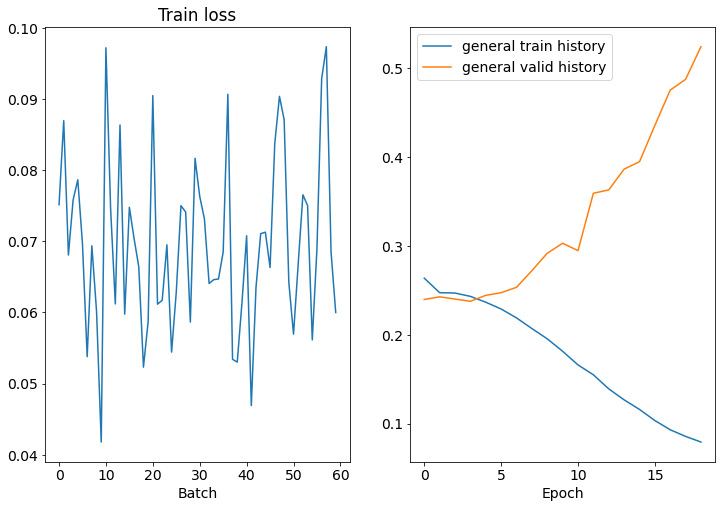

Epoch: 20 | Time: 0m 8s
	Train Loss: 0.071 | Train PPL:   1.073
	 Val. Loss: 0.515 |  Val. PPL:   1.673
top_k= 1
Count: 256
Ref: убийство пентагоном главы спецназа « аль-кудс » ирана касема сулеймани может серьезно обострить ситуацию в ближневосточном регионе — к такому выводу пришли президенты россии владимир путин и франции эммануэль макрон в телефонном разговоре . в тот же день глава мид россии сергей лавров и госсекретарь сша майк помпео обсудили по телефону атаку на сулеймани , и в ходе беседы российский министр раскритиковал действия вашингтона .
Hyp: президенты россии владимир путин и франции эммануэль макрон в телефонном разговоре , прошедшем в пятницу , 3 января , выразили озабоченность по поводу ликвидации американскими военными командующего силами специального назначения « аль-кудс » корпуса стражей исламской революции ирана касема сулеймани .
BLEU:  0.1951617055764109
ROUGE:  {'rouge-1': {'f': 0.27999793835109166, 'p': 0.44137925025270525, 'r': 0.21734463160292056}, 'rouge-

In [21]:
model = SentenceTaggerRNN(vocab_size, use_novelty=False).to(device)

train_all(False, N_EPOCHS, CLIP)

model.load_state_dict(torch.load('best-val-model.pt'))

top_k_inference_summarunner(model, test_iterator, 1)
top_k_inference_summarunner(model, test_iterator, 2)
top_k_inference_summarunner(model, test_iterator, 3)
top_k_inference_summarunner(model, test_iterator, 5)
threshold_inference_summarunner(model, test_iterator, 0.2)
threshold_inference_summarunner(model, test_iterator, 0.3)
threshold_inference_summarunner(model, test_iterator, 0.35)
threshold_inference_summarunner(model, test_iterator, 0.4)
threshold_inference_summarunner(model, test_iterator, 0.5)

## Обучим модель с весами и оценим ее качество

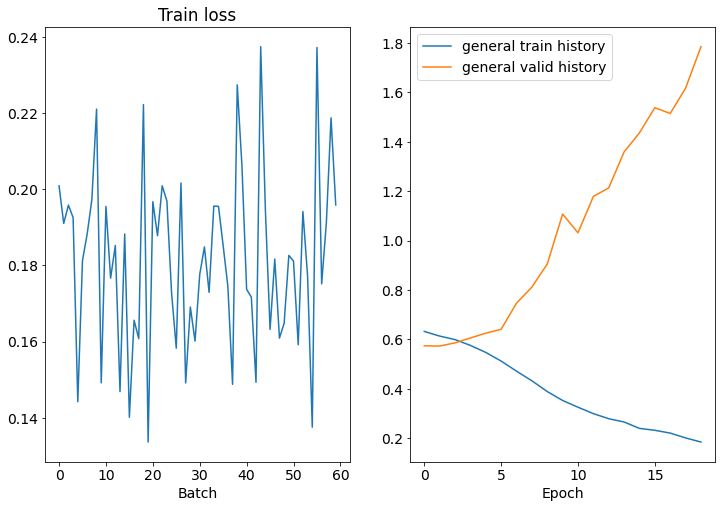

Epoch: 20 | Time: 0m 8s
	Train Loss: 0.180 | Train PPL:   1.198
	 Val. Loss: 1.905 |  Val. PPL:   6.720
top_k= 1
Count: 256
Ref: неандертальцы хоронили собратьев , соблюдая определенные ритуалы , считают ученые . новая находка позволяет предположить , что неандертальцы создавали подобия могил , а более ранние данные указывают на то , что , возможно , при погребениях использовались цветы .
Hyp: неандертальцы хоронили мертвецов с особыми ритуалами , считает команда исследователей под руководством специалистов из кембридского университета .
BLEU:  0.1974612047722521
ROUGE:  {'rouge-1': {'f': 0.2816651701712057, 'p': 0.44265913216514763, 'r': 0.21911648617808385}, 'rouge-2': {'f': 0.14088060542198771, 'p': 0.22634890714244005, 'r': 0.10919055716826959}, 'rouge-l': {'f': 0.2109489572734253, 'p': 0.3949881966030381, 'r': 0.19480953254794517}}
top_k= 2
Count: 256
Ref: убийство иранского генерала сулеймани , барическая пила от вильфанда , поражение сборной россии в финале молодежного чемпионат

In [22]:
model = SentenceTaggerRNN(vocab_size, use_novelty=False).to(device)

train_all(True, N_EPOCHS, CLIP)

model.load_state_dict(torch.load('best-val-model.pt'))

top_k_inference_summarunner(model, test_iterator, 1)
top_k_inference_summarunner(model, test_iterator, 2)
top_k_inference_summarunner(model, test_iterator, 3)
top_k_inference_summarunner(model, test_iterator, 5)
threshold_inference_summarunner(model, test_iterator, 0.2)
threshold_inference_summarunner(model, test_iterator, 0.3)
threshold_inference_summarunner(model, test_iterator, 0.35)
threshold_inference_summarunner(model, test_iterator, 0.4)
threshold_inference_summarunner(model, test_iterator, 0.5)

## Обучим модель c novelty и без весов и оценим ее качество

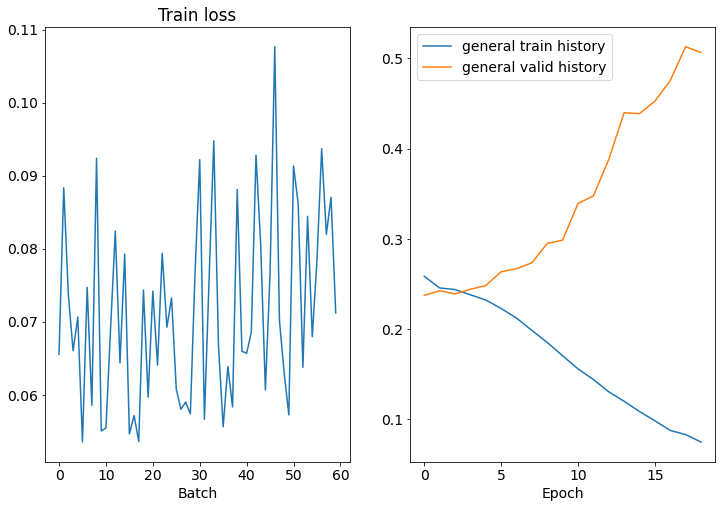

Epoch: 20 | Time: 0m 9s
	Train Loss: 0.071 | Train PPL:   1.074
	 Val. Loss: 0.493 |  Val. PPL:   1.637
top_k= 1
Count: 256
Ref: резкое похолодание придет в москву в конце следующей недели . несмотря на по-весеннему теплые рабочие будни , ближе к выходным ситуация кардинально изменится . по словам синоптиков , уже с четверга столицу начнет засыпать снегом , а столбики термометров опустятся до отметки в -8 °c . при этом на сколько морозная погода задержится в регионе метеорологи , пока умалчивают .
Hyp: резкое похолодание после аномального тепла придет в центральные и северо-западные регионы страны .
BLEU:  0.1974612047722521
ROUGE:  {'rouge-1': {'f': 0.2816651701712058, 'p': 0.4426591321651474, 'r': 0.21911648617808394}, 'rouge-2': {'f': 0.14088060542198758, 'p': 0.2263489071424402, 'r': 0.10919055716826961}, 'rouge-l': {'f': 0.2109489572734253, 'p': 0.39498819660303797, 'r': 0.19480953254794528}}
top_k= 2
Count: 256
Ref: в тегеране и в других городах ирана продолжаются массовые протес

In [23]:
model = SentenceTaggerRNN(vocab_size, use_novelty=True).to(device)

train_all(False, N_EPOCHS, CLIP)

model.load_state_dict(torch.load('best-val-model.pt'))

top_k_inference_summarunner(model, test_iterator, 1)
top_k_inference_summarunner(model, test_iterator, 2)
top_k_inference_summarunner(model, test_iterator, 3)
top_k_inference_summarunner(model, test_iterator, 5)
threshold_inference_summarunner(model, test_iterator, 0.2)
threshold_inference_summarunner(model, test_iterator, 0.3)
threshold_inference_summarunner(model, test_iterator, 0.35)
threshold_inference_summarunner(model, test_iterator, 0.4)
threshold_inference_summarunner(model, test_iterator, 0.5)

## Обучим модель с novelty и весами и оценим ее качество

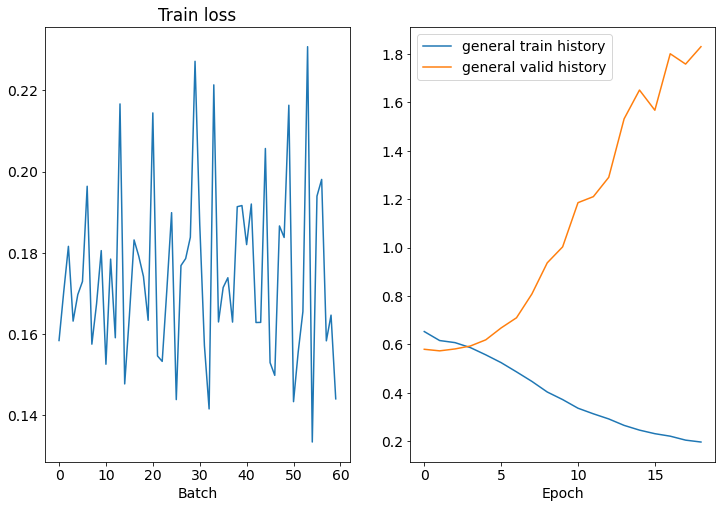

Epoch: 20 | Time: 0m 9s
	Train Loss: 0.175 | Train PPL:   1.191
	 Val. Loss: 2.318 |  Val. PPL:  10.160
top_k= 1
Count: 256
Ref: экипаж корабля « союз мс-16 » , который должен в апреле отправиться к мкс , заменят на дублеров , сообщили в роскосмосе . такое решение принято по медицинским показаниям , связанным с подготовкой на земле . неизвестно , сможет ли основной экипаж полететь в космос в будущем .
Hyp: российская часть экипажа корабля « союз мс-16 » , который должен лететь к международной космической станции ( мкс ) 9 апреля , будет заменена на дублеров , сообщает « риа новости » со ссылкой на исполнительного директора роскосмоса по пилотируемым программам сергея крикалева .
BLEU:  0.1974612047722521
ROUGE:  {'rouge-1': {'f': 0.2816651701712057, 'p': 0.4426591321651474, 'r': 0.2191164861780839}, 'rouge-2': {'f': 0.14088060542198777, 'p': 0.22634890714244002, 'r': 0.10919055716826957}, 'rouge-l': {'f': 0.21094895727342552, 'p': 0.3949881966030378, 'r': 0.19480953254794522}}
top_k= 2

In [24]:
model = SentenceTaggerRNN(vocab_size, use_novelty=True).to(device)

train_all(True, N_EPOCHS, CLIP)

model.load_state_dict(torch.load('best-val-model.pt'))

top_k_inference_summarunner(model, test_iterator, 1)
top_k_inference_summarunner(model, test_iterator, 2)
top_k_inference_summarunner(model, test_iterator, 3)
top_k_inference_summarunner(model, test_iterator, 5)
threshold_inference_summarunner(model, test_iterator, 0.2)
threshold_inference_summarunner(model, test_iterator, 0.3)
threshold_inference_summarunner(model, test_iterator, 0.35)
threshold_inference_summarunner(model, test_iterator, 0.4)
threshold_inference_summarunner(model, test_iterator, 0.5)

## Вывод:
- использование весов улучшает результаты, когда используем threshold-based inference_summarunner
- использование novelty не улучшает результат
- максимальное значение BLEU, которого удалось достичь - это 0.47